<a href="https://colab.research.google.com/github/corazon4815/deep-learning-Test/blob/main/keras_catdog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import drive
drive.mount('/content/gdrive') #gdrive계정을 연동시킴

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [37]:
!ls /content/gdrive/'My Drive'/deeplearning/projects -la  #!를 하면 커맨드 명령어를 칠수있음 projects폴더로 감
!cp /content/gdrive/'My Drive'/deeplearning/projects/dogs-vs-cats.zip . ##.을이용해서 여기로 zip파일을 현재위치로 옮겨줌

total 831618
-rw------- 1 root root 851576689 Oct 30 05:59 dogs-vs-cats.zip


In [38]:
!unzip dogs-vs-cats.zip -d catdog #unzip을 하면 압축이 풀리고 압축이 풀린다음에 -d를 이용해서 catdog라는 폴더를 만들어서 풀어줌

Archive:  dogs-vs-cats.zip
replace catdog/sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [39]:
!cd catdog; unzip train.zip; unzip test1.zip #catdog폴더로 이동해서 2개폴더를 unzip해줌

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520.jpg      
  inflating: train/dog.5521.jpg      
  inflating: train/dog.5522.jpg      
  inflating: train/dog.5523.jpg      
  inflating: train/dog.5524.jpg      
  inflating: t

In [40]:
!cd catdog/train; mkdir dogs; mkdir cats  #train폴더에 가서 dogs와 cats 폴더가 만들어짐

mkdir: cannot create directory ‘dogs’: File exists
mkdir: cannot create directory ‘cats’: File exists


In [41]:
!cd catdog/train; ls | grep -e cat |xargs mv -t cats
!cd catdog/train; ls | grep -e dog |xargs mv -t dogs

mv: cannot move 'cats' to a subdirectory of itself, 'cats/cats'
mv: cannot move 'dogs' to a subdirectory of itself, 'dogs/dogs'


In [42]:
!cd catdog/test1; mkdir dogs; mkdir cats

mkdir: cannot create directory ‘dogs’: File exists
mkdir: cannot create directory ‘cats’: File exists


In [43]:
!cd catdog/test1; ls | grep -e cat |xargs mv -t cats
!cd catdog/test1; ls | grep -e dog |xargs mv -t dogs

mv: cannot move 'cats' to a subdirectory of itself, 'cats/cats'
mv: cannot move 'dogs' to a subdirectory of itself, 'dogs/dogs'


In [44]:
!ls catdog/train/cats -la #cats폴더에 사진 있는지 확인하기

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
-rw-r--r-- 1 root root  22468 Sep 20  2013 cat.5501.jpg
-rw-r--r-- 1 root root  12534 Sep 20  2013 cat.5502.jpg
-rw-r--r-- 1 root root  22428 Sep 20  2013 cat.5503.jpg
-rw-r--r-- 1 root root  19215 Sep 20  2013 cat.5504.jpg
-rw-r--r-- 1 root root  32403 Sep 20  2013 cat.5505.jpg
-rw-r--r-- 1 root root   4510 Sep 20  2013 cat.5506.jpg
-rw-r--r-- 1 root root   3918 Sep 20  2013 cat.5507.jpg
-rw-r--r-- 1 root root  21615 Sep 20  2013 cat.5508.jpg
-rw-r--r-- 1 root root  33507 Sep 20  2013 cat.5509.jpg
-rw-r--r-- 1 root root  23424 Sep 20  2013 cat.550.jpg
-rw-r--r-- 1 root root  27507 Sep 20  2013 cat.5510.jpg
-rw-r--r-- 1 root root  16787 Sep 20  2013 cat.5511.jpg
-rw-r--r-- 1 root root  21842 Sep 20  2013 cat.5512.jpg
-rw-r--r-- 1 root root  24159 Sep 20  2013 cat.5513.jpg
-rw-r--r-- 1 root root  25427 Sep 20  2013 cat.5514.jpg
-rw-r--r-- 1 root root  61151 Sep 20  2013 cat.5515.jpg
-rw-r--r-- 1 root root   9213 Sep 20  2013 cat.5516.jpg
-rw-r--r-- 1 

##테라스 모델을 개발하자 

In [45]:
from keras.preprocessing.image import ImageDataGenerator


In [46]:
generator = ImageDataGenerator(rescale=1/255.) #이미지들로 데이터셋을 만드는 객체, 데이터를 0과 1사이로 만들기위해 255분의 1해줌

train_gen = generator.flow_from_directory('catdog/train', target_size=(64, 64),
                                          batch_size=32,
                                          class_mode='binary')
#flow_from_directory 이거는 경로에서 이미지를 읽어와서 resize를 하고 한번에 32개씩 묶어주고 두개의 클래스가있을때 하나는 0, 하나는 1로해줌 

Found 25000 images belonging to 2 classes.


In [47]:
next(train_gen) #파이썬 이터레이터 (next를 써주면 이미지랑 그에 해당하는 레이블들을 알려줌)
print(x_batch.shape)
print(y_batch.shape)

(32, 64, 64, 3)
(32,)


In [48]:
x_batch,y_batch = next(train_gen)
print(x_batch.shape)#(32, 64, 64, 3) -> 컬러니까 rgb채널=3 가로64 세로64가 32개 있다는 뜻
print(y_batch.shape)#(32,) -> binary(0,1)상황인게 32개라는뜻

(32, 64, 64, 3)
(32,)


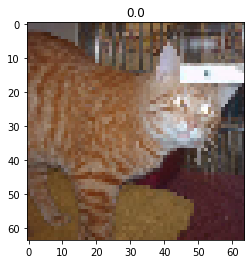

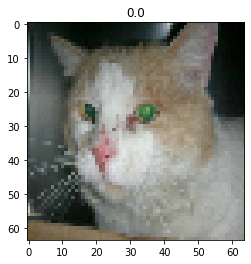

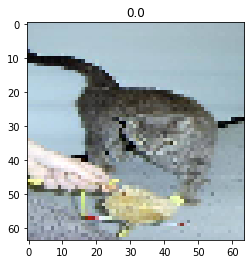

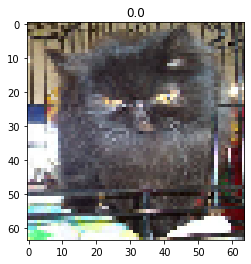

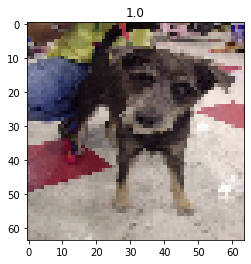

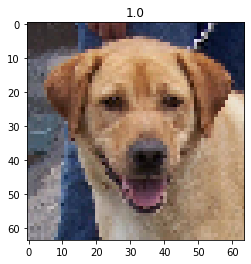

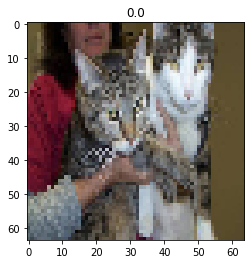

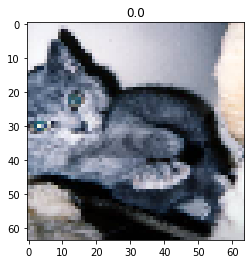

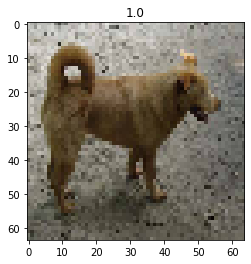

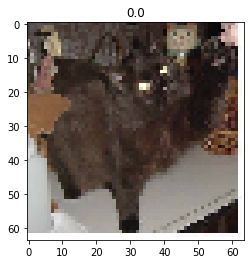

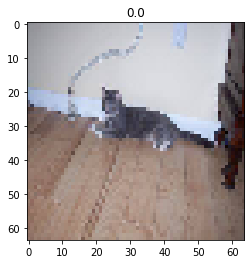

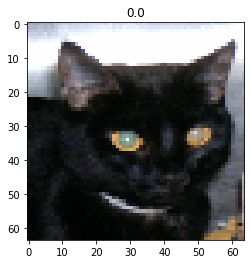

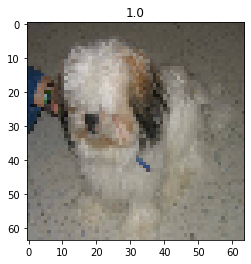

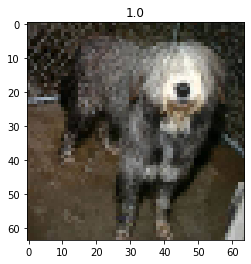

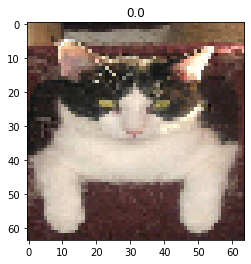

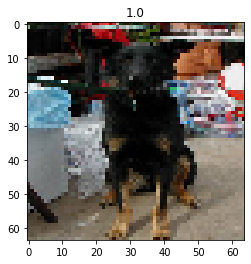

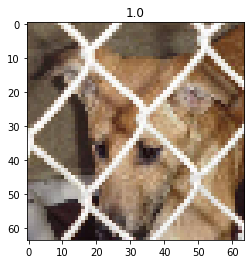

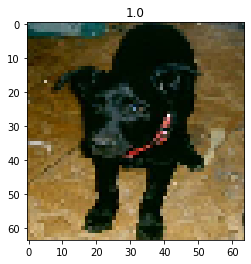

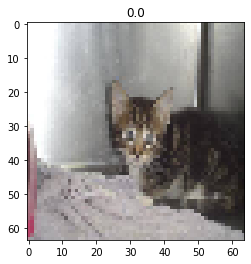

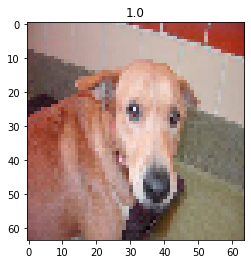

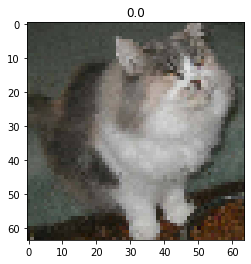

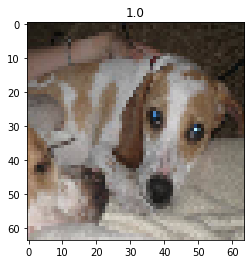

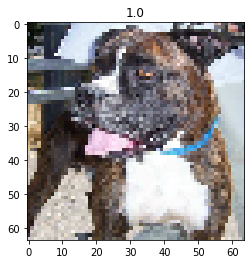

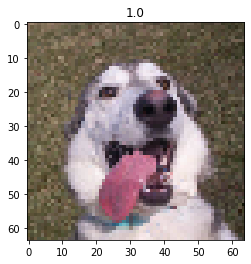

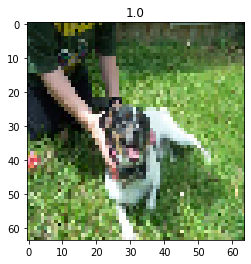

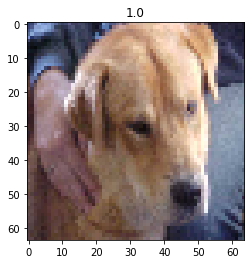

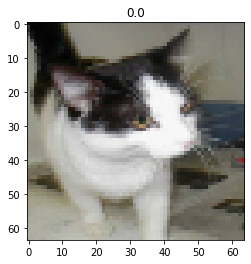

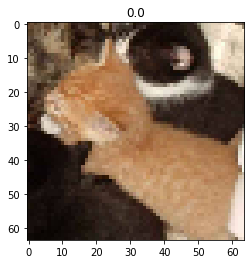

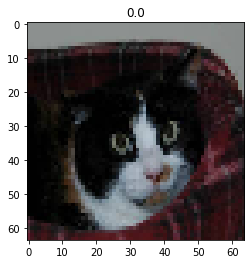

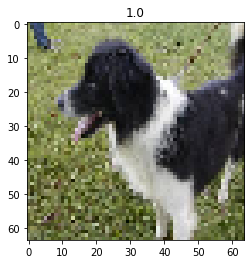

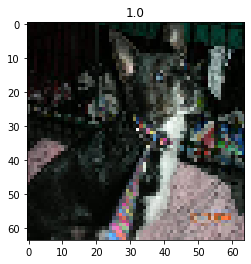

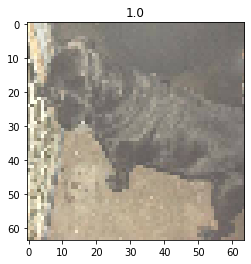

In [49]:
import matplotlib.pyplot as plt #이미지하고 레이블이 제대로돼있는지 확인
%matplotlib inline 

for i in range(len(x_batch)): #x_batch의 길이만큼 모두 나옴
  plt.imshow(x_batch[i])
  plt.title(y_batch[i])
  plt.show()

In [50]:
x_batch.max() #이미지들은 0부터 255사이의 rgb데이터임 가중치가 어떻게 초기화되느냐에 따라 수가 엄청 커지기때문에 레이블이 0또는 1 사이로 정해놨기 때문에
#데이터가 너무 커지는걸 막기위해 rexcale해줌

1.0

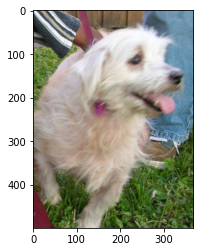

In [51]:
from PIL import Image #이미지 지정해서 출력해보기
img = Image.open('catdog/train/dogs/dog.9.jpg')
plt.imshow(img)
plt.show()

#모델을 만들어보자

In [52]:
from keras.layers import *
from keras.models import Model

def build_model():
  x = Input(shape=(64,64,3))
  out = x
#dense는 1차원 벡터에서만 사용가능하기때문에 데이터를 모두 한줄로 펼침
  out = Flatten()(out) #flatten 레이어를 이용해서 한줄로 펼침 한줄에 만이천정도 나옴(너무 크니까 줄여줌)
  out = Dense(512, activation='relu')(out)
  out = Dense(256, activation='relu')(out)
  out = Dense(64, activation='relu')(out)
  out = Dense(1, activation='sigmoid')(out) #sigmoid : 입력값이 커질수록 1로 수렴하고, 입력값이 작을수록 0에 수렴

  model = Model(x, out) #모델을 만들어줌
  return model      

In [53]:
model = build_model()
model.summary() #6백 40만 짜리 모델이 나옴 이제 이 모델을 학습함

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               6291968   
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 6,439,809
Trainable params: 6,439,809
Non-trainable params: 0
____________________________________________

In [62]:
model.compile(optimizer='sgd',loss='binary_crossentropy', metrics=['binary_accuracy']) #binary_crossentropy = t랑 y가 비슷할수록 loss가 적어짐 
#t의 범위가 레이블 0또는 1로줘서 0<=t<=1 t가 0에 가까우면 y(정답)도 0으로 가고 t가 1에 가까우면 y도 1로감 (레이블이 0과 1사이로 예측하는 모델에서만 사용가능)

history = model.fit(train_gen,epochs=10,steps_per_epoch=len(train_gen)) #Generator 데이터를 전체 돌면서 계속해서 데이터를 뿜어내기때문에
#epoch 한번을 찾아내려면 epoch에 몇번의 배치가 있는지 세줘야하는데 len(train_gen)로 해주면 총 배치수가 나옴  -학습중

Epoch 1/10
782/782 [==============================] - 88s 113ms/step - loss: 0.5782 - binary_accuracy: 0.6905
Epoch 2/10
782/782 [==============================] - 87s 112ms/step - loss: 0.5734 - binary_accuracy: 0.6962
Epoch 3/10
782/782 [==============================] - 87s 111ms/step - loss: 0.5660 - binary_accuracy: 0.7015
Epoch 4/10
782/782 [==============================] - 86s 110ms/step - loss: 0.5571 - binary_accuracy: 0.7089
Epoch 5/10
782/782 [==============================] - 86s 111ms/step - loss: 0.5518 - binary_accuracy: 0.7128
Epoch 6/10
782/782 [==============================] - 87s 111ms/step - loss: 0.5428 - binary_accuracy: 0.7204
Epoch 7/10
782/782 [==============================] - 87s 112ms/step - loss: 0.5373 - binary_accuracy: 0.7241
Epoch 8/10
782/782 [==============================] - 88s 112ms/step - loss: 0.5283 - binary_accuracy: 0.7340
Epoch 9/10
782/782 [==============================] - 88s 113ms/step - loss: 0.5206 - binary_accuracy: 0.7396
Epoch 10/1

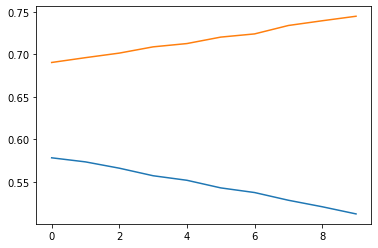

In [63]:
losses = history.history['loss']
accs = history.history['binary_accuracy']

plt.plot(losses,label='loss')
plt.plot(accs,label='acc')
plt.show()


test 결과를 보자!

In [55]:
test_gen = generator.flow_from_directory('catdog',target_size=(64,64), batch_size=32, classes=['test1']) #test1이라는 폴더에 있는걸 모두 가져와서generator로 만듦 

Found 12500 images belonging to 1 classes.


In [58]:
import numpy as np

x_tests, y_tests = [],[]
for i in range(len(test_gen)):
  x_test, y_test = next(test_gen)
  x_tests.append(x_test)
  y_tests.append(y_test) #데이터를 gen에서 전부 빼서 하나로 만드는일

  x_test = np.concatenate(x_tests, axis=0)
  y_test = np.concatenate(y_tests, axis=0)

  print(x_test.shape)
  print(y_test.shape)

(32, 64, 64, 3)
(32, 1)
(64, 64, 64, 3)
(64, 1)
(96, 64, 64, 3)
(96, 1)
(128, 64, 64, 3)
(128, 1)
(160, 64, 64, 3)
(160, 1)
(192, 64, 64, 3)
(192, 1)
(224, 64, 64, 3)
(224, 1)
(256, 64, 64, 3)
(256, 1)
(288, 64, 64, 3)
(288, 1)
(320, 64, 64, 3)
(320, 1)
(352, 64, 64, 3)
(352, 1)
(384, 64, 64, 3)
(384, 1)
(416, 64, 64, 3)
(416, 1)
(448, 64, 64, 3)
(448, 1)
(480, 64, 64, 3)
(480, 1)
(512, 64, 64, 3)
(512, 1)
(544, 64, 64, 3)
(544, 1)
(576, 64, 64, 3)
(576, 1)
(608, 64, 64, 3)
(608, 1)
(640, 64, 64, 3)
(640, 1)
(672, 64, 64, 3)
(672, 1)
(704, 64, 64, 3)
(704, 1)
(736, 64, 64, 3)
(736, 1)
(768, 64, 64, 3)
(768, 1)
(800, 64, 64, 3)
(800, 1)
(832, 64, 64, 3)
(832, 1)
(864, 64, 64, 3)
(864, 1)
(896, 64, 64, 3)
(896, 1)
(928, 64, 64, 3)
(928, 1)
(960, 64, 64, 3)
(960, 1)
(992, 64, 64, 3)
(992, 1)
(1024, 64, 64, 3)
(1024, 1)
(1056, 64, 64, 3)
(1056, 1)
(1088, 64, 64, 3)
(1088, 1)
(1120, 64, 64, 3)
(1120, 1)
(1152, 64, 64, 3)
(1152, 1)
(1184, 64, 64, 3)
(1184, 1)
(1216, 64, 64, 3)
(1216, 1)
(124

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


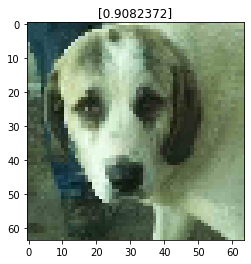

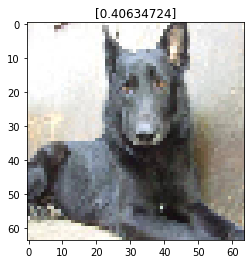

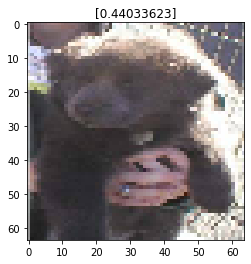

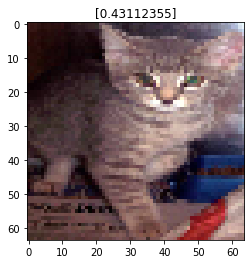

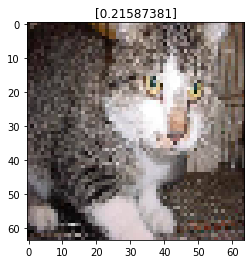

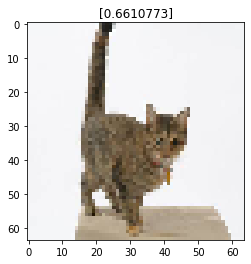

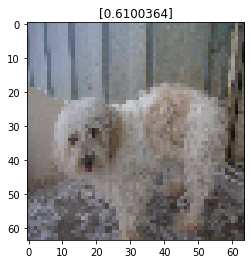

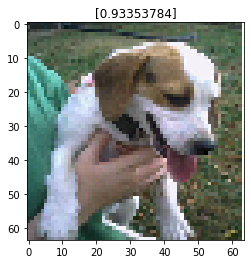

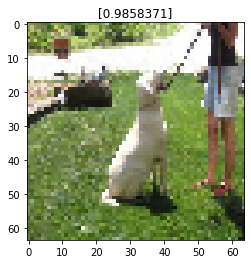

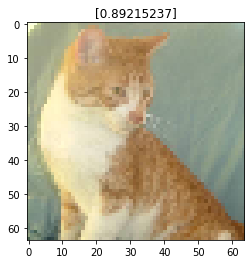

In [64]:
pred = model.predict(x_test[:10]) #pred를 만들어서 num파일을 넣어줘도됨
for i in range(10):
  plt.imshow(x_test[i])
  plt.title(pred[i])
  plt.show()
